<a href="https://colab.research.google.com/github/kmiyasararafath/Machine_Learning/blob/main/Ascendium_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Conclusions after understanding the data:**

1.   All the ad unit id's are independent and are not depend on site_id. But site_id might have an influence on the number of impressions.

2.   The characteristics for an adunit and their category count include


     Number of site_id                 =10
     Number of ad_unit_id              =132
     number of ad_type_id              =2 
     Number of device_category_id      =5
     Number of os_id                   =7
     Number of geo_id                  =219
     Number of intergration_type_id    =1 (not considered as it same for all)
     Number of monetization_channel_id =5
     Number of revenue_share_percent   =1 (not considered as all advertiser give full amount tp publisher)
    
3.   The characteristics of advertiser and number of categories inlcude


     Number of advertiser_id          =23 (not considered as advertiser is not known while fixing reserve price)
     
4.   The reserve price for an adunit should depend on the adunit characteristics and past impression/reserve price which are known prior. 
Assuming the advertiser is not known before the bidding.



    The system developed should be able to predict the reserve price from the adunit characteristics and past impressions

5.   Input variables 

**Categorical:**
     

     site_id
     ad_unit_id
     ad_type_id
     geo_id
     device_category_id
     os_id
     monetization_channel_id

**Numerical:**


     Total Impressions
     Viewable Impressions
     Measurable Impressions

6.   Output varable


    CPM or reserve price
                                                



##Assumptions:

1.  Advertiser is not known prior 
2.  The 'total_revenue' has values upto 4 decimal points and hence it is assumed to be in hundreds. Also currency is assumed as $.
3.  The publisher is auctioning the different versions of the ad_unit in different geo_id, device_category_id, os_id.
4.  The negative 'total revenue' values have been removed.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp /content/gdrive/MyDrive/Colab\ Notebooks/JOB_STUDIES/Ascendium/*.csv .

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!ls

Ascendeum_Dataset2.csv	gdrive	sample_data


In [ ]:
df=pd.read_csv("Ascendeum_Dataset2.csv")

In [ ]:
df.describe()

,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,integration_type_id,monetization_channel_id,ad_unit_id,total_impressions,total_revenue,viewable_impressions,measurable_impressions,revenue_share_percent
count,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.0,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.000000,567291.0
mean,347.107775,10.220578,110.226133,1.899669,262.084295,1951.273747,12.632081,57.217194,1.0,14.433716,5136.436645,33.673674,0.069740,12.838251,32.152818,1.0
std,2.930371,1.222863,66.177820,0.791982,627.325490,1652.545702,6.812571,1.956012,0.0,7.135874,62.508575,220.865448,0.713603,101.989184,207.096504,0.0
min,342.000000,10.000000,1.000000,1.000000,8.000000,45.000000,3.000000,15.000000,1.0,1.000000,5050.000000,0.000000,-0.154200,0.000000,0.000000,1.0
25%,345.000000,10.000000,39.000000,1.000000,79.000000,45.000000,4.000000,56.000000,1.0,4.000000,5099.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,346.000000,10.000000,122.000000,2.000000,88.000000,3438.000000,11.000000,57.000000,1.0,19.000000,5127.000000,2.000000,0.000000,0.000000,2.000000,1.0
75%,350.000000,10.000000,183.000000,3.000000,139.000000,3460.000000,19.000000,58.000000,1.0,19.000000,5168.000000,6.000000,0.005400,2.000000,6.000000,1.0
max,351.000000,17.000000,308.000000,5.000000,2646.000000,3489.000000,20.000000,60.000000,1.0,21.000000,5443.000000,14452.000000,83.822000,7392.000000,13756.000000,1.0


###Finding out the distinct ad locations for which reserve price needs to be found out 

In [ ]:
ad_unit_df=pd.read_csv("Ascendeum_Dataset2.csv",usecols=['ad_unit_id','site_id', 'ad_type_id', 'geo_id', 'device_category_id','os_id','monetization_channel_id'])
ad_unit_df

,site_id,ad_type_id,geo_id,device_category_id,os_id,monetization_channel_id,ad_unit_id
0,351,10,187,2,60,4,5174
1,351,10,187,2,58,4,5174
2,351,10,147,2,60,4,5174
3,351,10,147,2,58,4,5174
4,348,10,147,3,59,19,5138
...,...,...,...,...,...,...,...
567286,350,10,187,3,59,19,5168
567287,350,10,187,1,56,19,5168
567288,350,10,158,1,56,19,5168
567289,350,10,33,1,56,19,5168


In [ ]:
ad_unit_df=ad_unit_df.drop_duplicates()
ad_unit_df

,site_id,ad_type_id,geo_id,device_category_id,os_id,monetization_channel_id,ad_unit_id
0,351,10,187,2,60,4,5174
1,351,10,187,2,58,4,5174
2,351,10,147,2,60,4,5174
3,351,10,147,2,58,4,5174
4,348,10,147,3,59,19,5138
...,...,...,...,...,...,...,...
565916,342,10,187,1,56,1,5063
565950,350,10,171,2,60,1,5168
565962,350,10,15,2,57,1,5168
566355,350,10,80,3,59,1,5168


### Finding the total revenue and impressions in the month of June for the distinct ad locations

In [ ]:
new_df=pd.DataFrame()
for i, row in ad_unit_df.iterrows():

  check_df=df[(df['site_id']==ad_unit_df.at[i,'site_id'])&
              (df['ad_type_id']==ad_unit_df.at[i,'ad_type_id'])&
              (df['geo_id']==ad_unit_df.at[i,'geo_id'])&
              (df['device_category_id']==ad_unit_df.at[i,'device_category_id'])&
              (df['os_id']==ad_unit_df.at[i,'os_id'])&
              (df['monetization_channel_id']==ad_unit_df.at[i,'monetization_channel_id'])&
              (df['ad_unit_id']==ad_unit_df.at[i,'ad_unit_id'])
              ]

  t_impression=check_df['total_impressions'].sum()
  v_impression=check_df['viewable_impressions'].sum()
  m_impression=check_df['measurable_impressions'].sum()
  t_revenue=check_df['total_revenue'].sum()

  dict = {'site_id': ad_unit_df.at[i,'site_id'].astype(int), 'ad_type_id':int(ad_unit_df.at[i,'ad_type_id']), 
          'geo_id': ad_unit_df.at[i,'geo_id'],'device_category_id':ad_unit_df.at[i,'device_category_id'],
          'os_id': ad_unit_df.at[i,'os_id'],'monetization_channel_id':ad_unit_df.at[i,'monetization_channel_id'],
          'ad_unit_id': ad_unit_df.at[i,'ad_unit_id'],'total_impressions':t_impression,
          'viewable_impressions': v_impression,'measurable_impressions':m_impression,
          'total_revenue': t_revenue
          }
  new_df = new_df.append(dict, ignore_index = True)

new_df

,site_id,ad_type_id,geo_id,device_category_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,viewable_impressions,measurable_impressions,total_revenue
0,351.0,10.0,187.0,2.0,60.0,4.0,5174.0,252.0,18.0,252.0,0.4996
1,351.0,10.0,187.0,2.0,58.0,4.0,5174.0,566.0,98.0,564.0,2.3394
2,351.0,10.0,147.0,2.0,60.0,4.0,5174.0,4.0,0.0,4.0,0.0000
3,351.0,10.0,147.0,2.0,58.0,4.0,5174.0,4.0,0.0,4.0,0.0000
4,348.0,10.0,147.0,3.0,59.0,19.0,5138.0,4.0,0.0,4.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
40683,342.0,10.0,187.0,1.0,56.0,1.0,5063.0,2.0,2.0,2.0,0.0040
40684,350.0,10.0,171.0,2.0,60.0,1.0,5168.0,52.0,6.0,52.0,0.0780
40685,350.0,10.0,15.0,2.0,57.0,1.0,5168.0,4.0,2.0,4.0,0.0060
40686,350.0,10.0,80.0,3.0,59.0,1.0,5168.0,16.0,6.0,16.0,0.0320


In [ ]:
new_df.site_id=new_df.site_id.astype(int)
new_df.ad_type_id=new_df.ad_type_id.astype(int)
new_df.geo_id=new_df.geo_id.astype(int)
new_df.device_category_id=new_df.device_category_id.astype(int)
new_df.os_id=new_df.os_id.astype(int)
new_df.monetization_channel_id=new_df.monetization_channel_id.astype(int)
new_df.ad_unit_id=new_df.ad_unit_id.astype(int)
new_df

,site_id,ad_type_id,geo_id,device_category_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,viewable_impressions,measurable_impressions,total_revenue
0,351,10,187,2,60,4,5174,252.0,18.0,252.0,0.4996
1,351,10,187,2,58,4,5174,566.0,98.0,564.0,2.3394
2,351,10,147,2,60,4,5174,4.0,0.0,4.0,0.0000
3,351,10,147,2,58,4,5174,4.0,0.0,4.0,0.0000
4,348,10,147,3,59,19,5138,4.0,0.0,4.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
40683,342,10,187,1,56,1,5063,2.0,2.0,2.0,0.0040
40684,350,10,171,2,60,1,5168,52.0,6.0,52.0,0.0780
40685,350,10,15,2,57,1,5168,4.0,2.0,4.0,0.0060
40686,350,10,80,3,59,1,5168,16.0,6.0,16.0,0.0320


In [ ]:
new_df.describe()

,site_id,ad_type_id,geo_id,device_category_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,viewable_impressions,measurable_impressions,total_revenue
count,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000
mean,346.628023,10.360942,101.007791,1.987613,57.179955,13.909310,5135.722326,469.494003,178.996854,448.289520,0.972353
std,2.840736,1.548022,59.486645,0.810865,2.552809,7.456452,73.878517,7900.280636,3132.502275,7578.457988,18.801350
min,342.000000,10.000000,1.000000,1.000000,15.000000,1.000000,5050.000000,0.000000,0.000000,0.000000,0.000000
25%,345.000000,10.000000,48.000000,1.000000,56.000000,4.000000,5096.000000,0.000000,0.000000,0.000000,0.000000
50%,346.000000,10.000000,96.000000,2.000000,57.000000,19.000000,5120.000000,4.000000,2.000000,4.000000,0.000000
75%,349.000000,10.000000,156.000000,3.000000,59.000000,19.000000,5168.000000,20.000000,6.000000,18.000000,0.006400
max,351.000000,17.000000,308.000000,5.000000,60.000000,21.000000,5443.000000,757240.000000,265768.000000,746234.000000,1306.846800


### Finding the CPM or preserve price

In [ ]:
def divide_by_zero(a,b):
  return a/b if b else 0


In [ ]:
new_df['CPM']=new_df.apply(lambda x: divide_by_zero((x['total_revenue']*100),x['measurable_impressions'])*1000 , axis=1)

In [ ]:
idx=new_df['CPM']<0
new_df.drop(new_df.index[idx], inplace=True)
new_df.describe()


,site_id,ad_type_id,geo_id,device_category_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,viewable_impressions,measurable_impressions,total_revenue,CPM
count,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000
mean,346.628023,10.360942,101.007791,1.987613,57.179955,13.909310,5135.722326,469.494003,178.996854,448.289520,0.972353,59.649103
std,2.840736,1.548022,59.486645,0.810865,2.552809,7.456452,73.878517,7900.280636,3132.502275,7578.457988,18.801350,298.441063
min,342.000000,10.000000,1.000000,1.000000,15.000000,1.000000,5050.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,345.000000,10.000000,48.000000,1.000000,56.000000,4.000000,5096.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,346.000000,10.000000,96.000000,2.000000,57.000000,19.000000,5120.000000,4.000000,2.000000,4.000000,0.000000,0.000000
75%,349.000000,10.000000,156.000000,3.000000,59.000000,19.000000,5168.000000,20.000000,6.000000,18.000000,0.006400,51.727886
max,351.000000,17.000000,308.000000,5.000000,60.000000,21.000000,5443.000000,757240.000000,265768.000000,746234.000000,1306.846800,32510.000000


###Exploratory data analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

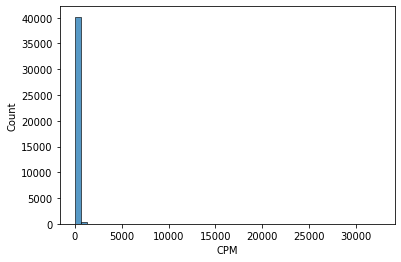

In [ ]:
sns.histplot(new_df.CPM[new_df.CPM < 33000],bins=50)

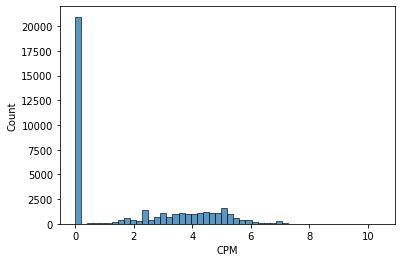

In [ ]:
cpm_log=np.log1p(new_df.CPM)
sns.histplot(cpm_log,bins=50)

In [ ]:
new_df['log_CPM']=cpm_log
new_df.describe()

,site_id,ad_type_id,geo_id,device_category_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,viewable_impressions,measurable_impressions,total_revenue,CPM,log_CPM
count,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000,40688.000000
mean,346.628023,10.360942,101.007791,1.987613,57.179955,13.909310,5135.722326,469.494003,178.996854,448.289520,0.972353,59.649103,1.904074
std,2.840736,1.548022,59.486645,0.810865,2.552809,7.456452,73.878517,7900.280636,3132.502275,7578.457988,18.801350,298.441063,2.172965
min,342.000000,10.000000,1.000000,1.000000,15.000000,1.000000,5050.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,345.000000,10.000000,48.000000,1.000000,56.000000,4.000000,5096.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,346.000000,10.000000,96.000000,2.000000,57.000000,19.000000,5120.000000,4.000000,2.000000,4.000000,0.000000,0.000000,0.000000
75%,349.000000,10.000000,156.000000,3.000000,59.000000,19.000000,5168.000000,20.000000,6.000000,18.000000,0.006400,51.727886,3.965144
max,351.000000,17.000000,308.000000,5.000000,60.000000,21.000000,5443.000000,757240.000000,265768.000000,746234.000000,1306.846800,32510.000000,10.389334


In [ ]:
new_df.corrwith(new_df['CPM'])

site_id                   -0.012402
ad_type_id                 0.048465
geo_id                     0.016405
device_category_id        -0.009065
os_id                     -0.024151
monetization_channel_id    0.030512
ad_unit_id                 0.050747
total_impressions          0.031631
viewable_impressions       0.036346
measurable_impressions     0.031170
total_revenue              0.061256
CPM                        1.000000
log_CPM                    0.359265
dtype: float64

###Splitting the given data to train and validation

In [ ]:
from sklearn.model_selection import train_test_split


40688
32550
8138


In [ ]:
# Importing the Ditionary Vectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Done to avoid data loss if the Google colab crashes
new_df.to_csv('modified_data_file.csv')

In [ ]:
!ls

Ascendeum_Dataset2.csv	gdrive	modified_data_file.csv	sample_data


In [ ]:
!cp modified_data_file.csv /content/gdrive/MyDrive/Colab\ Notebooks/JOB_STUDIES/Ascendium/

In [ ]:
y_train=df_train['log_CPM']
y_val=df_val['log_CPM']


In [ ]:
del df,ad_unit_df

In [ ]:
print(new_df['ad_unit_id'].nunique())
print(new_df['site_id'].nunique())
print(new_df['ad_type_id'].nunique())
print(new_df['geo_id'].nunique())
print(new_df['device_category_id'].nunique())
print(new_df['os_id'].nunique())
print(new_df['monetization_channel_id'].nunique())


132
10
2
219
5
7
5


####ONe hot encoding of the categorical data

In [ ]:
input_features=['ad_unit_id','site_id', 'ad_type_id', 'geo_id', 'device_category_id','os_id',
                'monetization_channel_id','total_impressions','viewable_impressions','measurable_impressions']
categorical_features=['ad_unit_id','site_id', 'ad_type_id', 'geo_id', 'device_category_id','os_id',
                      'monetization_channel_id']
numerical_features=['total_impressions','viewable_impressions','measurable_impressions']
train_df=new_df[categorical_features]


ohe = OneHotEncoder(sparse=False)
X = ohe.fit_transform(train_df) # It returns an numpy array
print(X.shape)
X

(40688, 380)


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#Adding the numerical data to categorical data
X=np.append(X,new_df[[numerical_features].values,axis=1)
print(X.shape)
X

(40688, 383)


array([[  0.,   0.,   0., ..., 252.,  18., 252.],
       [  0.,   0.,   0., ..., 566.,  98., 564.],
       [  0.,   0.,   0., ...,   4.,   0.,   4.],
       ...,
       [  0.,   0.,   0., ...,   4.,   2.,   4.],
       [  0.,   0.,   0., ...,  16.,   6.,  16.],
       [  0.,   0.,   0., ...,   2.,   0.,   2.]])

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X,new_df['log_CPM'],test_size=0.2, random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'X_val shape:   {X_val.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape:   {y_val.shape}')

X_train shape: (32550, 383)
X_val shape:   (8138, 383)
y_train shape: (32550,)
y_val shape:   (8138,)


### Modeling

In [ ]:
def my_rmse(y_pred,y_train):
  serr=(y_pred-y_train)**2
  m_serr=serr.mean()
  return np.sqrt(m_serr)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
scores=[]
scores_train=[]
for max_depth in [10,15,18,19,20]:
  dtreg=DecisionTreeRegressor(max_depth=max_depth)
  dtreg.fit(X_train,y_train)
  y_pred=dtreg.predict(X_val)
  rmse=my_rmse(y_pred,y_val)
  scores.append((max_depth,rmse))
  y_pred=dtreg.predict(X_train)
  rmse=my_rmse(y_pred,y_train)
  scores_train.append((max_depth,rmse))


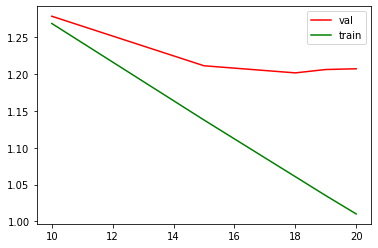

In [ ]:
df_score=pd.DataFrame(scores,columns=['max_depth','rmse'])
df_score_train=pd.DataFrame(scores_train,columns=['max_depth','rmse'])
plt.plot(df_score['max_depth'],df_score['rmse'],color='r',label='val')
plt.plot(df_score_train['max_depth'],df_score_train['rmse'], color='g', label='train')
plt.legend()
# plt.plot(df_score['num_estimators'],df_score['rmse'])

In [ ]:
scores=[]
scores_train=[]
for s in [1,2,3,4, 5]:
  dtreg=DecisionTreeRegressor(max_depth=15,min_samples_leaf=s)
  dtreg.fit(X_train,y_train)
  y_pred=dtreg.predict(X_val)
  rmse=my_rmse(y_pred,y_val)
  scores.append((s,rmse))
  y_pred=dtreg.predict(X_train)
  rmse=my_rmse(y_pred,y_train)
  scores_train.append((s,rmse))


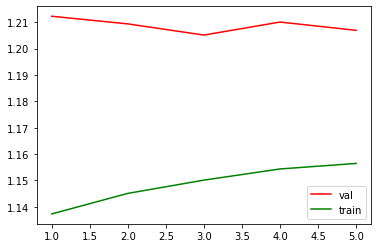

In [ ]:
df_score=pd.DataFrame(scores,columns=['s','rmse'])
df_score_train=pd.DataFrame(scores_train,columns=['s','rmse'])
plt.plot(df_score['s'],df_score['rmse'],color='r',label='val')
plt.plot(df_score_train['s'],df_score_train['rmse'], color='g', label='train')
plt.legend()
# plt.plot(df_score['num_estimators'],df_score['rmse'])

In [ ]:
max_depth=15
min_samples_leaf=3

In [ ]:
dtreg=DecisionTreeRegressor(max_depth=max_depth,min_samples_leaf=min_samples_leaf)
dtreg.fit(X_train,y_train)
  
y_pred=dtreg.predict(X_val)
rmse=my_rmse(y_pred,y_val)
print(round(rmse,3))

y_pred=dtreg.predict(X_train)
rmse=my_rmse(y_pred,y_train)
print(round(rmse,3))

1.206
1.15


In [ ]:
import xgboost as xgb

In [ ]:
xgb1=xgb.XGBRegressor(
    n_estimators=50,
    eta= 0.1, 
    max_depth= 15,
    min_child_weight= 3,
    
    verbosity= 1)

model = xgb1.fit(X_train,y_train)

[18:54:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred = model.predict(X_val)
rmse=my_rmse(y_pred,y_val)
print(round(rmse,3))

y_pred=model.predict(X_train)
rmse=my_rmse(y_pred,y_train)
print(round(rmse,3))

1.084
0.949


###Running for the entire june data

In [ ]:
X_train=X
y_train=new_df['log_CPM']
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')


X_train shape: (40688, 383)
y_train shape: (40688,)


In [ ]:
xgb1=xgb.XGBRegressor(
    n_estimators=500,
    eta= 0.1, 
    max_depth= 15,
    min_child_weight= 3,
    
    verbosity= 1)

model = xgb1.fit(X_train,y_train)

[18:59:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred=model.predict(X_train)
rmse=my_rmse(y_pred,y_train)
print(round(rmse,3))

0.603


In [ ]:
cpm_pred=model.predict(X_train)
print(y_pred.shape)

(40688,)


In [ ]:
new_df['predicted_log_CPM']=cpm_pred

In [ ]:
new_df['predicted_CPM']=np.expm1(new_df['predicted_log_CPM'])

### Checking whether the predicted CPM has deviation greater than 20%

In [ ]:
new_df['predicted_CPM_1']=new_df['predicted_CPM']
lcount=0
hcount=0
for (i, row) in new_df.iterrows():
  if new_df.at[i,'predicted_CPM']<0:
    new_df.at[i,'predicted_CPM']=0
  if new_df.at[i,'predicted_CPM']<=new_df.at[i,'CPM']:
    new_df.at[i,'predicted_CPM_1']=new_df.at[i,'CPM']
    lcount+=1
  if new_df.at[i,'predicted_CPM']>(new_df.at[i,'CPM']*1.2):
    new_df.at[i,'predicted_CPM_1']=(new_df.at[i,'CPM']*1.2)
    hcount+=1

print(lcount)
print(hcount)

20096
17101


In [ ]:
new_df

,site_id,ad_type_id,geo_id,device_category_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,viewable_impressions,measurable_impressions,total_revenue,CPM,log_CPM,predicted_log_CPM,predicted_CPM,predicted_CPM_1,predicted_total_revenue,predicted_total_revenue_1
0,351,10,187,2,60,4,5174,252.0,18.0,252.0,0.4996,198.253968,5.294580,5.357021,211.092148,211.092148,0.531952,0.531952
1,351,10,187,2,58,4,5174,566.0,98.0,564.0,2.3394,414.787234,6.030174,6.221992,502.705383,497.744690,2.835258,2.807280
2,351,10,147,2,60,4,5174,4.0,0.0,4.0,0.0000,0.000000,0.000000,0.108996,0.115158,0.000000,0.000005,0.000000
3,351,10,147,2,58,4,5174,4.0,0.0,4.0,0.0000,0.000000,0.000000,1.480755,3.396266,0.000000,0.000136,0.000000
4,348,10,147,3,59,19,5138,4.0,0.0,4.0,0.0000,0.000000,0.000000,-0.124501,0.000000,0.000000,-0.000005,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40683,342,10,187,1,56,1,5063,2.0,2.0,2.0,0.0040,200.000000,5.303305,3.364953,27.932146,200.000000,0.000559,0.004000
40684,350,10,171,2,60,1,5168,52.0,6.0,52.0,0.0780,150.000000,5.017280,4.954412,140.799133,150.000000,0.073216,0.078000
40685,350,10,15,2,57,1,5168,4.0,2.0,4.0,0.0060,150.000000,5.017280,4.672925,106.010345,150.000000,0.004240,0.006000
40686,350,10,80,3,59,1,5168,16.0,6.0,16.0,0.0320,200.000000,5.303305,5.049265,154.907898,200.000000,0.024785,0.032000


In [ ]:
new_df['predicted_total_revenue']=new_df['predicted_CPM']*new_df['measurable_impressions']/100000
new_df['predicted_total_revenue_1']=new_df['predicted_CPM_1']*new_df['measurable_impressions']/100000

In [ ]:
new_df

,site_id,ad_type_id,geo_id,device_category_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,viewable_impressions,measurable_impressions,total_revenue,CPM,log_CPM,predicted_log_CPM,predicted_CPM,predicted_CPM_1,predicted_total_revenue,predicted_total_revenue_1
0,351,10,187,2,60,4,5174,252.0,18.0,252.0,0.4996,198.253968,5.294580,5.357021,211.092148,211.092148,0.531952,0.531952
1,351,10,187,2,58,4,5174,566.0,98.0,564.0,2.3394,414.787234,6.030174,6.221992,502.705383,497.744690,2.835258,2.807280
2,351,10,147,2,60,4,5174,4.0,0.0,4.0,0.0000,0.000000,0.000000,0.108996,0.115158,0.000000,0.000005,0.000000
3,351,10,147,2,58,4,5174,4.0,0.0,4.0,0.0000,0.000000,0.000000,1.480755,3.396266,0.000000,0.000136,0.000000
4,348,10,147,3,59,19,5138,4.0,0.0,4.0,0.0000,0.000000,0.000000,-0.124501,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40683,342,10,187,1,56,1,5063,2.0,2.0,2.0,0.0040,200.000000,5.303305,3.364953,27.932146,200.000000,0.000559,0.004000
40684,350,10,171,2,60,1,5168,52.0,6.0,52.0,0.0780,150.000000,5.017280,4.954412,140.799133,150.000000,0.073216,0.078000
40685,350,10,15,2,57,1,5168,4.0,2.0,4.0,0.0060,150.000000,5.017280,4.672925,106.010345,150.000000,0.004240,0.006000
40686,350,10,80,3,59,1,5168,16.0,6.0,16.0,0.0320,200.000000,5.303305,5.049265,154.907898,200.000000,0.024785,0.032000


In [ ]:
print(new_df['predicted_total_revenue'].sum())
print(new_df['predicted_total_revenue_1'].sum())

38141.759036022704
40777.385014887965


### Predicted total revenue during the month of July


In [ ]:
july_revenue_min=new_df['predicted_total_revenue'].sum()*(1+(1/30))
july_revenue_max=new_df['predicted_total_revenue_1'].sum()*(1+(1/30))
print(f'Predicted minimum revenue during July: {july_revenue_min}')
print(f'Predicted maximum revenue during July: {july_revenue_max}')

Predicted minimum revenue during July: 39413.15100389013
Predicted maximum revenue during July: 42136.6311820509


In [ ]:
new_df['total_revenue'].sum()

39563.1192

In [ ]:
reserve_price_df=new_df[['ad_unit_id','site_id', 'ad_type_id', 'geo_id', 'device_category_id','os_id','monetization_channel_id','predicted_CPM_1']]
reserve_price_df

,ad_unit_id,site_id,ad_type_id,geo_id,device_category_id,os_id,monetization_channel_id,predicted_CPM_1
0,5174,351,10,187,2,60,4,211.092148
1,5174,351,10,187,2,58,4,497.744690
2,5174,351,10,147,2,60,4,0.000000
3,5174,351,10,147,2,58,4,0.000000
4,5138,348,10,147,3,59,19,0.000000
...,...,...,...,...,...,...,...,...
40683,5063,342,10,187,1,56,1,200.000000
40684,5168,350,10,171,2,60,1,150.000000
40685,5168,350,10,15,2,57,1,150.000000
40686,5168,350,10,80,3,59,1,200.000000


In [ ]:
reserve_price_df.to_csv('reserve_price_july.csv')


In [ ]:
!cp reserve_price_july.csv /content/gdrive/MyDrive/Colab\ Notebooks/JOB_STUDIES/Ascendium/